In [1]:
file_input, cube_size = 'input_test.txt', 4
#file_input, cube_size = 'input.txt', 50

In [2]:
import numpy as np

In [3]:
with open(file_input) as f:
    filetxt = f.read()

In [4]:
map,moves = filetxt.split('\n\n')

In [5]:
map = map.split('\n')

In [6]:
map

['        ...#',
 '        .#..',
 '        #...',
 '        ....',
 '...#.......#',
 '........#...',
 '..#....#....',
 '..........#.',
 '        ...#....',
 '        .....#..',
 '        .#......',
 '        ......#.']

In [7]:
moves=moves.strip('\n')

In [8]:
moves

'10R5L5R10L4R5L5'

In [9]:
#Test splitting the moves
import re
re.findall( "[R|L]|[0-9]+", moves)

['10', 'R', '5', 'L', '5', 'R', '10', 'L', '4', 'R', '5', 'L', '5']

In [10]:
moves_list = re.findall( "[R|L]|[0-9]+", moves)
moves_list

['10', 'R', '5', 'L', '5', 'R', '10', 'L', '4', 'R', '5', 'L', '5']

# Parse map

Convert map to a numpy array of int8

In [11]:
VOID=0
TILE=1
WALL=2

In [12]:
conv_dict={' ':VOID , '.':TILE , '#':WALL}

need to figure out dimensions of the map

In [13]:
ysize = len(map)
ysize

12

In [14]:
xsize=0
for l0 in map:
    lsize = len(l0)
    xsize=max(xsize,lsize)
xsize

16

Create array with these dimensions and fill with the elements

In [15]:
map_np = np.zeros((ysize,xsize), dtype=np.int8)

for iy, l0 in enumerate(map):
    for ix,char in enumerate(l0):
        map_np[iy,ix] = conv_dict[char]

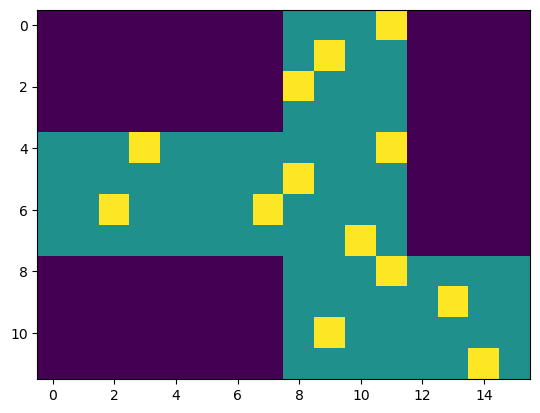

In [16]:
import matplotlib.pyplot as plt
plt.imshow(map_np)

Setup directions

In [17]:
DIR_UP=(-1,0)
DIR_DOWN=(1,0)
DIR_LEFT=(0,-1)
DIR_RIGHT=(0,1)

In [18]:
Lrot_dict={DIR_UP:DIR_LEFT , DIR_DOWN:DIR_RIGHT , DIR_LEFT:DIR_DOWN , DIR_RIGHT:DIR_UP} #counterclockwise
Rrot_dict={DIR_UP:DIR_RIGHT , DIR_DOWN:DIR_LEFT , DIR_LEFT:DIR_UP , DIR_RIGHT:DIR_DOWN} #clockwise

# Setup the cubefaces

Create a class that contains the cube face info, location in original map, and connectivity

In [19]:
RIGHT=0
DOWN=1
LEFT=2
UP=3

In [20]:
class cFace:
    def __init__(self, facedata, map_position, tag):
        self.map_position = map_position
        self.facedata = facedata

        self.whoAtSide=[None,None, None, None] #in order as above, right, bootom, left, top
        self.tag=tag
    def __str__(self):

        s = f"Cube face {self.tag}, from map_position {self.map_position}, connected to "
        for s0 in self.whoAtSide:
            if not s0 is None:
                s+= f"; {s0[0].tag},{s0[1]}"
            else:
                s+="; None "
        return s


In [21]:
#Parse map to create initial cFace objects

cubefaces = []
iface=0

for iy in range(0, map_np.shape[0], cube_size):
    for ix in range( 0, map_np.shape[1], cube_size):
        face = map_np[iy:iy+cube_size , ix:ix+cube_size]

        if face[0,0]!=VOID:
            #Valid face, add to cubeface at the right location

            print(f"face found, iy:{iy} , ix:{ix}")
            cFace0 = cFace(face, [iy,ix], iface)

            cubefaces.append(cFace0)
            iface+=1

face found, iy:0 , ix:8
face found, iy:4 , ix:0
face found, iy:4 , ix:4
face found, iy:4 , ix:8
face found, iy:8 , ix:8
face found, iy:8 , ix:12


In [22]:
print(cubefaces[0])

Cube face 0, from map_position [0, 8], connected to ; None ; None ; None ; None 


In [23]:
#Sort simple obvious connectivity, from coordinates

for i0,c0 in enumerate(cubefaces):
    for i1 in range(i0, len(cubefaces)):
        c1 = cubefaces[i1]

        #left or right edge
        if c0.map_position[0] == c1.map_position[0]: #Same row coordinate
            if c0.map_position[1]+cube_size == c1.map_position[1] :
                c0.whoAtSide[RIGHT] = (c1,LEFT)
                c1.whoAtSide[LEFT]= (c0,RIGHT)
            elif c0.map_position[1]==0 and c1.map_position[1]+cube_size==4*cube_size:
                c0.whoAtSide[LEFT] = (c1,RIGHT)
                c1.whoAtSide[RIGHT] = (c0, LEFT)

        #Top to bottom
        if c0.map_position[1] == c1.map_position[1]: #same col coordinate
            if c0.map_position[0]+cube_size == c1.map_position[0]:
                c0.whoAtSide[DOWN] = (c1,UP)
                c1.whoAtSide[UP] = (c0,DOWN)
            if c0.map_position[0]==0 and c1.map_position[0]+cube_size==4*cube_size:
                c0.whoAtSide[UP] = (c1,DOWN)
                c1.whoAtSide[DOWN] = (c0,UP)

In [25]:
for c0 in cubefaces:
    print(c0)

Cube face 0, from map_position [0, 8], connected to ; None ; 3,3; None ; None 
Cube face 1, from map_position [4, 0], connected to ; 2,2; None ; None ; None 
Cube face 2, from map_position [4, 4], connected to ; 3,2; None ; 1,0; None 
Cube face 3, from map_position [4, 8], connected to ; None ; 4,3; 2,0; 0,1
Cube face 4, from map_position [8, 8], connected to ; 5,2; None ; None ; 3,1
Cube face 5, from map_position [8, 12], connected to ; None ; None ; 4,0; None 


OK

For each cube look for faces around corners and connect as appropriate

In [26]:
dir_clockw_dict = {RIGHT:DOWN , DOWN:LEFT , LEFT:UP, UP:RIGHT}
dir_cclockw_dict = {RIGHT:UP , DOWN:RIGHT , LEFT:DOWN, UP:LEFT}

In [27]:
print(cubefaces[0])

Cube face 0, from map_position [0, 8], connected to ; None ; 3,3; None ; None 


In [28]:
bThereWereNoneConnections = True

i=0
while bThereWereNoneConnections:
    bThereWereNoneConnections = False
    i+=1
    print(f"i:{i}")
    for c0 in cubefaces:
        check_order = [ (c0.whoAtSide[RIGHT], c0.whoAtSide[DOWN]) , (c0.whoAtSide[DOWN], c0.whoAtSide[LEFT]), (c0.whoAtSide[LEFT], c0.whoAtSide[UP]), (c0.whoAtSide[UP], c0.whoAtSide[RIGHT]) ]

        for w1,w2 in check_order:
            if (not w1 is None) and (not w2 is None):
                c1,side1 = w1
                c2,side2 = w2
                print(f"face {c0.tag} has two other faces at 90degrees, {c1.tag} and {c2.tag} ")

                #Check counterclockwise side
                side1_c = dir_cclockw_dict[side1]
                side2_c = dir_clockw_dict[side2]

                #Check if there is connection already
                if c1.whoAtSide[side1_c] is None:
                    print(f"face {c1.tag} has no connection at side {side1_c}")
                    print("c1: ", c1)
                    print("c2: ", c2)
                    assert c2.whoAtSide[side2_c] is None
                    bThereWereNoneConnections=True
                    #Connect them
                    c1.whoAtSide[side1_c]= (c2,side2_c)
                    c2.whoAtSide[side2_c]= (c1,side1_c)
                    
                    print("After connection:")
                    print("c1: ", c1)
                    print("c2: ", c2)


i:1
face 3 has two other faces at 90degrees, 4 and 2 
face 4 has no connection at side 2
c1:  Cube face 4, from map_position [8, 8], connected to ; 5,2; None ; None ; 3,1
c2:  Cube face 2, from map_position [4, 4], connected to ; 3,2; None ; 1,0; None 
After connection:
c1:  Cube face 4, from map_position [8, 8], connected to ; 5,2; None ; 2,1; 3,1
c2:  Cube face 2, from map_position [4, 4], connected to ; 3,2; 4,2; 1,0; None 
face 3 has two other faces at 90degrees, 2 and 0 
face 2 has no connection at side 3
c1:  Cube face 2, from map_position [4, 4], connected to ; 3,2; 4,2; 1,0; None 
c2:  Cube face 0, from map_position [0, 8], connected to ; None ; 3,3; None ; None 
After connection:
c1:  Cube face 2, from map_position [4, 4], connected to ; 3,2; 4,2; 1,0; 0,2
c2:  Cube face 0, from map_position [0, 8], connected to ; None ; 3,3; 2,3; None 
face 4 has two other faces at 90degrees, 2 and 3 
face 4 has two other faces at 90degrees, 3 and 5 
face 3 has no connection at side 0
c1:  Cu

In [29]:
for c0 in cubefaces:
    print(c0)

Cube face 0, from map_position [0, 8], connected to ; 5,0; 3,3; 2,3; 1,3
Cube face 1, from map_position [4, 0], connected to ; 2,2; 4,1; 5,1; 0,3
Cube face 2, from map_position [4, 4], connected to ; 3,2; 4,2; 1,0; 0,2
Cube face 3, from map_position [4, 8], connected to ; 5,3; 4,3; 2,0; 0,1
Cube face 4, from map_position [8, 8], connected to ; 5,2; 1,1; 2,1; 3,1
Cube face 5, from map_position [8, 12], connected to ; 0,0; 1,2; 4,0; 3,0


# Movement algorithm

In [72]:
def rot90(y,x,dir,k=0):
    rot_centre = (cube_size-1)/2

    y0=y-rot_centre
    x0=x-rot_centre
    dir0=dir
    for i in range(k):
        #Rotates counterclockwise
        y1 = x0
        x1 = -y0
        y0=y1
        x0=x1
        dir0 = Rrot_dict[dir0]

    y1 = int(y0+rot_centre)
    x1= int(x0+rot_centre)
    return y1,x1, dir0
rot90(1,0, (1,0),1)

(3, 1, (0, -1))

In [64]:
def doStepCube(cface0, y0,x0 , dir0):

    #pos is position within the face_number given

    y = y0 #new positions start
    x = x0

    new_face = cface0

    newdir = dir0

    #Move one step
    y+=dir0[0]
    x+=dir0[1]

    #Check for over-the-edge movement
    # If goes over the edge, then move it to new face and adjust direction
    
    if x<0:
        assert dir0==DIR_LEFT

        #Check for face in the
        new_face, new_side = cface0.whoAtSide[LEFT]
        print("x<0, next face", new_face.tag)

        x=cube_size-1 #Default if side of the other cube is RIGHT
        #Translate coordinates based on the new side
        nrot= (new_side-RIGHT) %4
        y,x,newdir = rot90(y,x,newdir, nrot)
        print(f"y,x: {y},{x}, newdir:{newdir} , nrot:{nrot}")
    
    if x>=cube_size:
        assert dir0==DIR_RIGHT
        #Check for face in the
        new_face, new_side = cface0.whoAtSide[RIGHT]
        print("x>=cube_size, next face", new_face.tag)
        
        x=0 #Default if side of the other cube is RIGHT
        #Translate coordinates based on the new side
        nrot= (new_side-LEFT) %4
        y,x, newdir = rot90(y,x,newdir, nrot)
        print(f"y,x: {y},{x}, newdir:{newdir} , nrot:{nrot}")

    if y<0:
        assert dir0==DIR_UP
        new_face, new_side = cface0.whoAtSide[UP]
        print("y<0, next face", new_face.tag)
        y=cube_size-1
        nrot= (new_side-DOWN) %4
        y,x, newdir = rot90(y,x,newdir, nrot)
        print(f"y,x: {y},{x}, newdir:{newdir} , nrot:{nrot}")
        
    if y>=cube_size:
        assert dir0==DIR_DOWN
        new_face, new_side = cface0.whoAtSide[DOWN]
        print("y>=cube_size, next face", new_face.tag)
        y=0
        nrot= (new_side-UP) %4
        y,x, newdir = rot90(y,x,newdir, nrot)
        print(f"y,x: {y},{x}, newdir:{newdir} , nrot:{nrot}")

    #Check if it is wall
    if new_face.facedata[y,x] == WALL:
        return None #Cannot move, so stop

    assert new_face.facedata[y,x] == TILE

    print(f"check: y,x: {y},{x}, newdir:{newdir}")
    #Return new position, new direction and face
    return new_face, y,x, newdir

do movements

In [65]:
#Starting position and direction

my_y, my_x = 0, 0
my_face = cubefaces[0]
my_dir = DIR_RIGHT

print(f"starting location, cface:{my_face.tag}, pos:{my_y},{my_x}, direction:{my_dir}")
for m0 in moves_list:
    print(f"Move {m0}")
    if m0.isnumeric():
        #Makes the move N times
        steps = int(m0)
        #print(f"Numeric move, steps {steps}")
        for i in range(steps):
            print(f"i:{i}")
            res = doStepCube(my_face, my_y, my_x, my_dir)
            #print(f"res:{res}")
            if res is None:
                print("Hit wall")
                break
            else:
                my_face, my_y, my_x, my_dir = res
                print(f"cface:{my_face.tag}, pos:{my_y},{my_x}, direction:{my_dir}")

    else:
        #Instruction is a turn
        if m0=='R':
            #Clockwise
            newdir = Rrot_dict[my_dir]
        else:
            assert m0=='L'
            newdir= Lrot_dict[my_dir]
        my_dir=newdir
    print(f"position after move, cface:{my_face.tag}, pos:{my_y},{my_x}, direction:{my_dir}")

starting location, cface:0, pos:0,0, direction:(0, 1)
Move 10
i:0
check: y,x: 0,1, newdir:(0, 1)
cface:0, pos:0,1, direction:(0, 1)
i:1
check: y,x: 0,2, newdir:(0, 1)
cface:0, pos:0,2, direction:(0, 1)
i:2
Hit wall
position after move, cface:0, pos:0,2, direction:(0, 1)
Move R
position after move, cface:0, pos:0,2, direction:(1, 0)
Move 5
i:0
check: y,x: 1,2, newdir:(1, 0)
cface:0, pos:1,2, direction:(1, 0)
i:1
check: y,x: 2,2, newdir:(1, 0)
cface:0, pos:2,2, direction:(1, 0)
i:2
check: y,x: 3,2, newdir:(1, 0)
cface:0, pos:3,2, direction:(1, 0)
i:3
y>=cube_size, next face 3
y,x: 0,2, newdir:(1, 0) , nrot:0
check: y,x: 0,2, newdir:(1, 0)
cface:3, pos:0,2, direction:(1, 0)
i:4
check: y,x: 1,2, newdir:(1, 0)
cface:3, pos:1,2, direction:(1, 0)
position after move, cface:3, pos:1,2, direction:(1, 0)
Move L
position after move, cface:3, pos:1,2, direction:(0, 1)
Move 5
i:0
check: y,x: 1,3, newdir:(0, 1)
cface:3, pos:1,3, direction:(0, 1)
i:1
x>=cube_size, next face 5
y,x: 3,1, newdir:(1, 0) 

Now try to extract position in the map

In [48]:
face_map_pos = my_face.map_position
face_map_pos

[4, 8]

In [49]:
#Convert final position and face to map position
y1 = my_y + face_map_pos[0]
x1 = my_x + face_map_pos[1]
dir1= my_dir

print(f"Final position in map y1:{y1}, x1:{x1} , dir1:{dir1}")

Final position in map y1:6, x1:8 , dir1:(0, -1)


In [ ]:
score_dir_dict = {DIR_RIGHT:0, DIR_DOWN:1, DIR_LEFT:2, DIR_UP:3 }

In [ ]:
row = pos[0]+1
col = pos[1]+1
dir_score = score_dir_dict[dir]

In [ ]:
1000*row+4*col+dir_score

OK